In [ ]:
# Imports and dataset
import torch
import math
import os
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
from utils import get_optimizer

import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# MNIST Handwriting Dataset
train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

batch_size = 64
trainset = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
optimizer_names = ["SGD", "Adam"]
epochs = 10
model_save_interval = int(epochs * len(trainset) / 1000)
num_backprops = 0
model_dir = "./models"


print(f"Num training batches: {len(trainset)}")

In [ ]:
# Simple MLP network for MNIST classification
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
loss_function = nn.CrossEntropyLoss()

In [ ]:
# Initialize network, hooks, and optimizer
import torchvision
from collections import deque

for optim_name in optimizer_names:
    print("Training Network with", optim_name)
    # Intialize network
    net = Net()
    optimizer = get_optimizer(optim_name, net.parameters())
    losses = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    # Train for certain number of epochs
    for epoch in range(epochs):
        print('Epoch:', epoch)
        # Loop over the dataset
        epoch_loss = 0
        # Mini-batch gradient descent
        for X, y in trainset:
            X, y = X.to(device), y.to(device)
            grads = np.zeros(8)
            net.zero_grad()
            output = net(X.view(-1,784))
            loss = F.nll_loss(output, y)
            epoch_loss += loss
            loss.backward()
            optimizer.step()
            # Save model
            if num_backprops % model_save_interval == 0:
                torch.save(net.state_dict(), os.path.join(model_dir, f"{optim_name}_model_{num_backprops}.pt"))
            num_backprops += 1
        print("Loss:", epoch_loss.item()/len(trainset))
        losses.append(loss)


In [ ]:
from OptimTrajViz import get_param_matrix
param_matrix = get_param_matrix("SGD_model_", model_dir)
print(np.shape(param_matrix.T))

In [ ]:
from sklearn.decomposition import PCA, IncrementalPCA
# Subtract the last parameter vector from all vectors
param_dist_matrix = param_matrix - param_matrix[-1,:]
param_dist_matrix = param_dist_matrix[:-1, :]
# Compute PCA on difference matrix
print("Computing PCA...")
pca = PCA(n_components=3)
pca_param_diff = pca.fit(param_dist_matrix)


In [17]:
# Print principal components and singular values
print(pca.components_)
print(pca.singular_values_)
print(pca.explained_variance_ratio_)
# Project parameters onto matrix
projected_param_matrix = pca_param_diff.transform(param_matrix)
print(np.shape(projected_param_matrix))

[[ 7.2536486e-12  1.7866834e-12  5.5994380e-13 ... -1.6251616e-02
   7.7542913e-04 -2.6630981e-02]
 [-1.9890061e-07  1.3330605e-12  1.7598316e-13 ... -5.3414587e-02
   7.2856443e-03  2.1139588e-02]
 [ 6.7002848e-06  1.9093594e-07  3.5000496e-13 ... -2.0903142e-02
   2.3581818e-02 -4.8836719e-02]]
[12.691093   2.1055143  0.6245598]
[0.9703393  0.02670803 0.00235003]
(1043, 3)


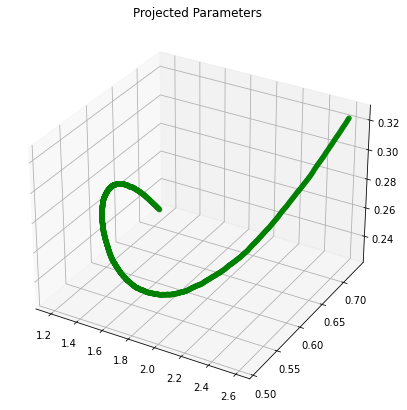

In [19]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
x = projected_param_matrix[:, 0]
y = projected_param_matrix[:, 1]
z = projected_param_matrix[:, 2]

# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("Projected Parameters")
 
# show plot
plt.show()